In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
from sklearn.preprocessing import MinMaxScaler
import random
import time

In [2]:
training_data=pd.read_csv('C:\Shubh\Study MAterial\ml\datasets\mnist\mnist_train.csv')
testing_data=pd.read_csv('C:\Shubh\Study MAterial\ml\datasets\mnist\mnist_test.csv')

In [3]:
ytest=np.array(testing_data['label'])
Xtest=np.array(testing_data.drop(['label'],axis=1))

In [4]:
#activations for testing
def relu(z):
    a= np.maximum(z, 0)
    return a

def tanh(z):
    return np.tanh(z)

def sigmoid(z):
    a= (1/(1+np.exp(-z)))
    return a

def softmax(x):
    z= np.exp(x) / np.sum(np.exp(x), axis=0)
    return z

In [5]:
def relu_prime(z):
    a=(z>0)*1
    return a

def sigmoid_prime(z):
    return sigmoid(z) * (1-sigmoid(z))

def tanh_prime(z):
    return 1 - np.power(tanh(z), 2)

#we calculate softmax prime directly as when we use cross entropy as loss function then softmax derivative is equal to y_pred-y

In [6]:
y=np.array(training_data['label'])                        #y=training labels
Xdata=np.array(training_data.drop(['label'],axis=1))      #Xdata=training features                  
yorig=y                                                   #yorig=y(so it stores original y as we will do one hot encoding on y
                                                          # So we need it to test accuracy on training data)

In [7]:
#doing one hot encoding
#train label=contains one hot encoded target variables
train_label=np.zeros((10,60000))
for col in range (60000):
    val=y[col]
    for row in range (10):
        if (val==row):
            train_label[val,col]=1
print("train_label shape="+str(np.shape(train_label)))
y=train_label

#scaling training and testing features by same scale
scaler=MinMaxScaler()
X=scaler.fit_transform(Xdata)
Xtest=scaler.fit_transform(Xtest)

train_label shape=(10, 60000)


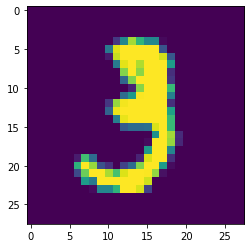

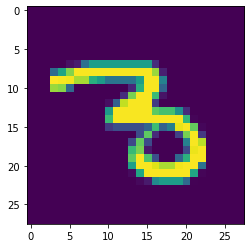

In [8]:
plt.imshow(X[10].reshape((28,28)))
plt.show()
plt.imshow(X[30].reshape((28,28)))

In [9]:
def forward_propogation(xtrain,n_layers,parameters,activation,keep_probb):
    cache=[]
    a_prev=xtrain.T
    for l in range(1,n_layers):
        #dropout
        D1 = np.random.rand(a_prev.shape[0], a_prev.shape[1])                               # Step 1: initialize matrix D1 = np.random.rand(..., ...)
        D1 = D1 < keep_prob                                         # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
        a_prev = np.multiply(a_prev, D1)                                         # Step 3: shut down some neurons of A1
        a_prev = a_prev/keep_prob  
        
        z=np.dot(parameters["w"+str(l)],a_prev)+parameters["b"+str(l)]
        cache.append([parameters["w"+str(l)],parameters["b"+str(l)],a_prev,z,D1])
        a_prev=relu(z)
        
    z=np.dot(parameters["w"+str(n_layers)],a_prev)+parameters["b"+str(n_layers)]
    cache.append([parameters["w"+str(n_layers)],parameters["b"+str(n_layers)],a_prev,z])
    
    if(activation=="softmax"):
        a_prev=softmax(z)
    elif(activation=="tanh"):
        a_prev=tanh(z)
        a_prev=(a_prev+1)/2
    else:
        a_prev=sigmoid(z)
    
    return cache,a_prev                  #returning cache and predicted values

In [10]:
def backward_propogation(Y,cache,AL,n_layers,lambd,m,activation,keep_prob):
    grads={}
    w,b,a,z=cache[n_layers-1]                
    m = a.shape[1]
    
    if(activation=="softmax"):
        dZ = AL-Y             
    elif(activation=="tanh"):
        #dAL = AL-Y       #quadratic loss function
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        dZ=np.multiply(dAL,tanh_prime(z))
    else:
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        dZ=np.multiply(dAL,sigmoid_prime(z))
        
    #print(dZ)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dW = (1/m)*(np.dot(dZ,a.T))
    dA=np.dot(w.T,dZ)
    dW+=w*(lambd/m)
    db+=b*(lambd/m)
    grads["dw" + str(n_layers)], grads["db" + str(n_layers)]=dW,db
    
    for i in range(n_layers-1,0,-1):
        w,b,a,z,drop=cache[i-1]
        m = a.shape[1]
        
        dZ=np.multiply(dA,relu_prime(z))
        db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
        dW = (1/m)*(np.dot(dZ,a.T))
        dA=np.dot(w.T,dZ)
       
        #applying dropout
        
        dA=np.multiply(dA,drop)
        if(i==1):
            keep_prob=1
        dA=dA/keep_prob
        
        #regularization
        dW+=w*(lambd/m)
        db+=b*(lambd/m)
        grads["dw" + str(i)], grads["db" + str(i)]=dW,db
        
    return grads

In [11]:
def initialize_parameters(n_layers,model_name,parameters):
    terms={}
    if(model_name=='sgdm'):  #sgd with momentum
        for l in range(1,n_layers+1):
            terms["vdw" + str(l)] = np.zeros(parameters["w" + str(l)].shape)
            terms["vdb" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        
    elif(model_name=='rmsprop'):
        for l in range(1,n_layers+1):
            terms["sdw" + str(l)] = np.zeros(parameters["w" + str(l)].shape)
            terms["sdb" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
    
    elif(model_name=='adam'):
        for l in range(1,n_layers+1):
            terms["vdw" + str(l)] = np.zeros(parameters["w" + str(l)].shape)
            terms["vdb" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
            terms["sdw" + str(l)] = np.zeros(parameters["w" + str(l)].shape)
            terms["sdb" + str(l)] = np.zeros(parameters["b" + str(l)].shape)

    return terms

In [12]:
def update_parameters(parameters,grads,learning_rate,n_layers,model_name,par,terms):
    epsilon=1e-8
    if(model_name=='sgdm'):  #sgd with momentum
        #initializing parameters
        beta=par['beta']
        for l in range(1,n_layers+1):
            
            terms['vdw'+str(l)]=beta*terms['vdw'+str(l)]+(1-beta)*grads["dw"+str(l)]
            terms['vdb'+str(l)]=beta*terms['vdb'+str(l)]+(1-beta)*grads["db"+str(l)]
            parameters["w"+str(l)]-=learning_rate*terms['vdw'+str(l)]
            parameters["b"+str(l)]-=learning_rate*terms['vdb'+str(l)]
        
            
    elif(model_name=='rmsprop'):
        beta=par['beta']
        for l in range(1,n_layers+1):
            terms['sdw'+str(l)]=beta*terms['sdw'+str(l)]+(1-beta)*np.square(grads["dw"+str(l)])
            terms['sdb'+str(l)]=beta*terms['sdb'+str(l)]+(1-beta)*np.square(grads["db"+str(l)])
            parameters["w"+str(l)]-=(learning_rate*(grads["dw"+str(l)]/(np.sqrt(terms['sdw'+str(l)])+epsilon)))
            parameters["b"+str(l)]-=(learning_rate*(grads["db"+str(l)]/(np.sqrt(terms['sdb'+str(l)])+epsilon)))
            
            
    elif(model_name=='adam'):
        betav,betas=par['betav'],par['betas']
        for l in range(1,n_layers+1):
            terms['vdw'+str(l)]=betav*terms['vdw'+str(l)]+(1-betav)*grads["dw"+str(l)]
            terms['vdb'+str(l)]=betav*terms['vdb'+str(l)]+(1-betav)*grads["db"+str(l)]
            terms['sdw'+str(l)]=betas*terms['sdw'+str(l)]+(1-betas)*np.square(grads["dw"+str(l)])
            terms['sdb'+str(l)]=betas*terms['sdb'+str(l)]+(1-betas)*np.square(grads["db"+str(l)])

            parameters["w"+str(l)]-=learning_rate*(terms['vdw'+str(l)]/(np.sqrt(terms['sdw'+str(l)])+epsilon))
            parameters["b"+str(l)]-=learning_rate*(terms['vdb'+str(l)]/(np.sqrt(terms['sdb'+str(l)])+epsilon))
            
    else:    
        for l in range(1,n_layers+1):
            parameters["w"+str(l)]-=learning_rate*grads["dw"+str(l)]
            parameters["b"+str(l)]-=learning_rate*grads["db"+str(l)]
            
    return parameters,terms

In [13]:
def prediction(x,parameters,activation):
    a_prev=x.T
    for l in range(1,n_layers):
        z=np.dot(parameters["w"+str(l)],a_prev)+parameters["b"+str(l)]
        a_prev=relu(z)
        plt.imshow(a_prev.T[10])
        plt.show()
        plt.imshow(a_prev.T[130])
        plt.show()
    
    z=np.dot(parameters["w"+str(n_layers)],a_prev)+parameters["b"+str(n_layers)]
    if(activation=="softmax"):
        a_prev=softmax(z)
    elif(activation=="tanh"):
        a_prev=tanh(z)
    else:
        a_prev=sigmoid(z)
    
    a_prev=a_prev.T
    acc=[]
    for i in a_prev:
        k=list(i)
        acc.append(k.index(max(k)))
    return acc

In [14]:
def model(x,y,yorig,Xtest,ytest,model_name,n_layers,neurons_array,epochs,learning_rate,activation,mini_batch_size,lambd,keep_prob,par):
    parameters={}
    prev=x.shape[1]
    costarr=[]
    trainaccuracy=[]
    testaccuracy=[]
    timer=[]
    #initializing weights
    for l in range(n_layers):
        parameters['w'+str(l+1)]=np.random.randn(neurons_array[l],prev)*np.sqrt(2/prev)
        parameters['b'+str(l+1)]=np.zeros((neurons_array[l],1))
        prev=neurons_array[l]
        print(parameters['w'+str(l+1)].shape,parameters['b'+str(l+1)].shape)
    len(param)
    progress=0     #for seeing how much percent of model has been trained
    
    #initializing terms accoriding to model
    terms=initialize_parameters(n_layers,model_name,parameters)
    #terms will contain variables only for sgdm,rmsprop and adam
    
    time1=time.time()
    
    for j in range(epochs):
        print("executing",j)       
        
        ind=np.arange(0,60000)
        np.random.shuffle(ind)

        i=0
        
        
        while(i<x.shape[0]):
            print(((progress/x.shape[0])*100)/epochs,"%progress done")
            
            xtrain=x[ind[i:i+mini_batch_size]]
            ytrain=y.T[ind[i:i+mini_batch_size]].T
            yorignew=yorig[ind[i:i+mini_batch_size]]
            i+=mini_batch_size
            progress+=mini_batch_size
            
            
            cache,AL=forward_propogation(xtrain,n_layers,parameters,activation,keep_prob)
            #calculating cost
            m=ytrain.shape[1]
            
            if(activation=="softmax"):
                cost = (-1 / m) * np.sum(np.multiply(ytrain, np.log(AL)))
            elif(activation=="tanh"):
                cost=(1/m)*np.sum(np.square(AL-ytrain))
            else:
                cost = (-1 /m ) * np.sum(np.multiply(ytrain, np.log(AL)) + np.multiply(1 - ytrain, np.log(1 - AL)))
            regcost=0
            for l in range(n_layers):
                w=parameters['w'+str(l+1)]
                regcost+=(lambd*np.sum(np.square(w)))/(2*m)
            cost+=regcost
            
            
            grads=backward_propogation(ytrain,cache,AL,n_layers,lambd,m,activation,keep_prob)
            
            parameters,terms=update_parameters(parameters,grads,learning_rate,n_layers,model_name,par,terms)
            #print(parameters)
            time2=time.time()
            testaccuracy.append(accuracy_score(prediction(Xtest,parameters,activation),ytest))
            trainaccuracy.append(accuracy_score(prediction(xtrain,parameters,activation),yorignew))
            timer.append(time2-time1)
            costarr.append(cost)
            #if(timer[len(timer)-1]>400):
             #   return parameters,costarr,testaccuracy,trainaccuracy,grads,terms,timer
            
            

    return parameters,costarr,testaccuracy,trainaccuracy,grads,terms,timer

In [15]:
model_name="adam"
mini_batch_size=128
#after fixing mini batch size,other paramters can be optimized except momentum as it depends on batch size
par={}                #model parameters for sgdm,rmsprop and adam
if(model_name=="sgd"):
    mini_batch_size=1
elif(model_name=="gd"):
    mini_batch_size=X.shape[0]
elif(model_name=='sgdm'):
    par['beta']=0.8
elif(model_name=='rmsprop'):
    par['beta']=0.999
elif(model_name=='adam'):
    par['betav'],par['betas']=0.8,0.999
    

neurons_array=[256,128,64,1]
n_layers=len(neurons_array)
epochs=10
learning_rate=0.001
activation="sigmoid"
lambd=0
keep_prob=0.8
t1=time.time()
parameters,costarr,testaccuracy,trainaccuracy,grads,terms,timer=model(X,y,yorig,Xtest,ytest,model_name,n_layers,neurons_array,
                                                         epochs,learning_rate ,activation,mini_batch_size,lambd,keep_prob,par)
t2=time.time()
tim=t2-t1

(256, 784) (256, 1)
(128, 256) (128, 1)
(64, 128) (64, 1)
(1, 64) (1, 1)
executing 0
0.0 %progress done


ValueError: shapes (64,1) and (10,128) not aligned: 1 (dim 1) != 10 (dim 0)

In [ ]:
pred1 = prediction(Xtest,parameters,activation)
pred2= prediction(X,parameters,activation)
print("Model name=",model_name)
print("Activation=",activation)
print("Learning rate=",learning_rate)
print("Epochs=",epochs)
print("Mini batch size=",mini_batch_size)
print("L2 regularization parameter=",lambd)
print("Dropout parameter=",keep_prob)
print("Model parameter=",par)
print("Hidden layers=",neurons_array)
print("Test accuracy=",accuracy_score(pred1,ytest)*100,"%")
print("Train accuracy=",accuracy_score(pred2,yorig)*100,"%")
print("Time=",tim)

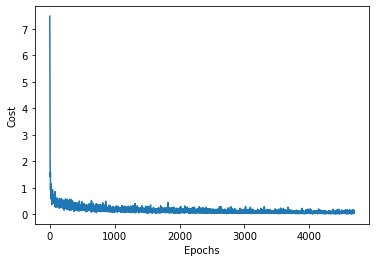

In [34]:
plt.plot(np.arange(1,len(costarr)+1),costarr)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

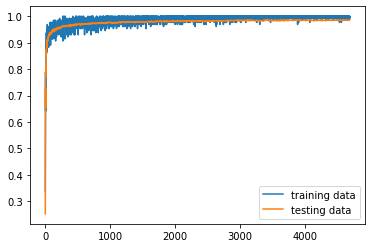

In [35]:
plt.plot(np.arange(1,len(trainaccuracy)+1),trainaccuracy,label="training data")
plt.plot(np.arange(1,len(trainaccuracy)+1),testaccuracy,label="testing data")
plt.legend()
plt.show()

In [30]:
print(max(testaccuracy) ,"at", testaccuracy.index(max(testaccuracy)))

0.9867 at 4224


In [31]:
j=4224
timer[j],testaccuracy[j],trainaccuracy[j]

(2397.9117934703827, 0.9867, 1.0)

In [20]:
len(testaccuracy)

4690

In [21]:
slope=(testaccuracy[j]-testaccuracy[j-1])
slope

0.0009000000000000119

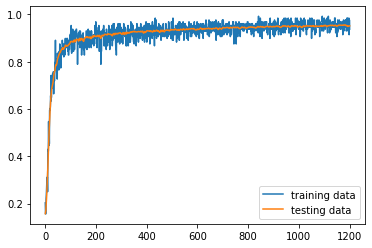

In [22]:
plt.plot(np.arange(1,j+1),trainaccuracy[:j],label="training data")
plt.plot(np.arange(1,j+1),testaccuracy[:j],label="testing data")
#plt.plot([17,17],[0.4,0.8])
plt.legend()
plt.show()

In [188]:
def gradient_checking(X,y,n_layers,lambd,parameters,activation,keep_prob,epsilon=1e-7):
    keys=parameters.keys()
    grads_check={}
    grads={}
    m=y.shape[1]
    
    cache,AL=forward_propogation(X,n_layers,parameters,activation,keep_prob)
    grad=backward_propogation(y,cache,AL,n_layers,lambd,m,activation,keep_prob)
    
    for i in reversed(list(grad.keys())):
        if(i[1]=='w'):
            grads[i]=grad[i]
            
        
    for i in keys:
        if(i[0]=='w'):
            parameters_plus= parameters.copy()
            parameters_minus=parameters.copy()
            parameters_plus[i] = parameters_plus[i] + epsilon
            parameters_minus[i]= parameters_minus[i] - epsilon
             
            cache1,aplus=forward_propogation(X,n_layers,parameters_plus,activation,keep_prob)
            cache2,aminus=forward_propogation(X,n_layers,parameters_minus,activation,keep_prob)
            
            if(activation=="softmax"):
                costplus = aplus-y
                costminus= aminus-y
            
            #costplusss = (-1 / m) * np.sum(np.multiply(y, np.log(aplus)))
            #print(costplusss)
            
            grads_check["d"+i]=(aplus.T-aminus.T)/(2*epsilon)
            print(grads_check["d"+i].shape,grads["d"+i].shape)
    
    print(grads)
    print("-----------------------------------------------------------------")
    print(grads_check)
    numerator = np.linalg.norm(grads - grads_check)                                     
    denominator = np.linalg.norm(grads) + np.linalg.norm(grads)
    difference = numerator / denominator
    
    if difference > 10e-7:
        print("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")

In [ ]:
#gradient_checking(X,y,n_layers,lambd,parameters,activation,keep_prob)

In [ ]:
Rmsprop and adam were giving nan vauesif learning rate was greater than or equal to 0.1 but why was it happening because values
were not that large ki 1 iteration me nan ho jaae
at 0.05 gave only 73% accuracy while at 0.01 gave 96%
at 0.08 it became nan but very after in cmparison to 0.1 means 17%
at 0.07 also nan at 28.59%progress
at 0.06 no nan but accuracy 52%
at 0.03 gave 80% accuracy

In [ ]:
Test Accuracy with softmax as last layer activation function with learning rate 0.001 epochs 10 regularization parameter 0
droput prob 1 mini_batch_size 128 and layers as [500, 10] is 98.15 % and training accuracy is 99.91833333333334 % with adam

In [ ]:
parameters to check for vary-neurons_array,epochs,learning_rate,activation,mini_batch_size,lambd,keep_prob,par for all models
models-adam,sgdm,rmsprop,mbgd,sgd,gd,

In [ ]:
also see by using different cost function like cross entropy,quadratic loss at last